# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [2]:
%%capture
#!pip install spacy
#!pip install spacy[transformers]
!pip install -q torchvision
#!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm
!pip install -q catboost
#!pip install  spacy download en_core_web_sm
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl

In [ ]:
import torchvision.models as models
import torch
import torch.nn as nn
import numpy as np
#import tensorflow as tf
import math
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.image as mpimg
import spacy
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
#from skorch.callbacks import EpochScoring, EarlyStopping
#from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
#import torch
#import torch.nn as nn
from math import ceil
import catboost

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Serge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Импортируем данные.

In [ ]:
train_dataset = pd.read_csv('to_upload/train_dataset.csv')
CrowdAnnotations = pd.read_csv('to_upload/CrowdAnnotations.tsv', sep='\t', header=None)
ExpertAnnotations = pd.read_csv('to_upload/ExpertAnnotations.tsv', sep='\t', header=None)
test_queries = pd.read_csv('to_upload/test_queries.csv', sep='|', index_col=0)
test_images = pd.read_csv('to_upload/test_images.csv', sep='|')

In [ ]:
train_dataset.sample(10)

,image,query_id,query_text
1340,1352410176_af6b139734.jpg,533483374_86c5d4c13e.jpg#2,a dog on the beach .
5617,3071676551_a65741e372.jpg,2160266952_a2ab39191b.jpg#2,Two children dressed in black bounce on red an...
3117,2182488373_df73c7cc09.jpg,1433142189_cda8652603.jpg#2,A man with a big backpack is walking through a...
2878,270724499_107481c88f.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
778,2543589122_ec3e55f434.jpg,3602838407_bf13e49243.jpg#2,A dog stands in a tide pool
3119,2764178773_d63b502812.jpg,1433142189_cda8652603.jpg#2,A man with a big backpack is walking through a...
3217,1836335410_de8313a64e.jpg,2602085456_d1beebcb29.jpg#2,A topless woman is covered in mud .
78,2575647360_f5de38c751.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...
5218,2928152792_b16c73434a.jpg,3655074079_7df3812bc5.jpg#2,A naked woman wearing body paint riding a bicy...
4665,3259666643_ae49524c81.jpg,2301525531_edde12d673.jpg#2,A black and white dog runs over snow by a tree...


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [ ]:
train_dataset.duplicated().sum()

0

В тренировочном датасете 5822 строк, или в среднем 5,8 описаний  на каждую из 1000 изображений.

In [ ]:
train_dataset.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


При этом уникальных запросов  977

In [ ]:
CrowdAnnotations = pd.read_csv('to_upload/ExpertAnnotations.tsv',  sep='\t', header=None, names=['image', 'query_id', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'])
CrowdAnnotations.head(10)

,image,query_id,percentage_confirmed,quantity_confirmed,quantity_disproved
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2


In [ ]:
CrowdAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   image                 5822 non-null   object
 1   query_id              5822 non-null   object
 2   percentage_confirmed  5822 non-null   int64 
 3   quantity_confirmed    5822 non-null   int64 
 4   quantity_disproved    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [ ]:
CrowdAnnotations.duplicated().sum()

0

In [ ]:
CrowdAnnotations.describe()

,percentage_confirmed,quantity_confirmed,quantity_disproved
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Около 9% из опрошенных подтверждают, что описание соответствует изображению. При этом, имеется максимальное значение — 1, что означает, что есть изображения с описанием, релевантность которого подвердили абсолютно все "краудсорсеры".

In [ ]:
ExpertAnnotations = pd.read_csv('to_upload/ExpertAnnotations.tsv', sep='\t', header=None, names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
ExpertAnnotations.head(10)

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2


In [ ]:
ExpertAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [ ]:
ExpertAnnotations.duplicated().sum()

0

In [ ]:
ExpertAnnotations.describe()

,expert_1,expert_2,expert_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Третий эксперт оценивает сходство запроса и картинки выше остальных экспертов (среднее 1,88 против 1,4 и 1,6)

In [ ]:
test_queries = pd.read_csv('to_upload/test_queries.csv', sep='|', index_col=0)
test_queries.head(10)

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg


In [ ]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [ ]:
test_queries.duplicated().sum()

0

In [ ]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


Видим 100 изображений, по 5 запросов на каждое.

### ВЫВОДЫ

 * Проведена загрузка данных и созданы переменные для них.
 * Обнаружено, что в работе на краудсорсинге соответствие текстового запроса изображению отмечается менее, чем в 9% случаев.
 * Эксперты в целом также невысоко оценивают соответствие текста изображению, их средние оценки колеблются в диапазоне 1,4-1,9 баллов из 4 и можно сделать вывод что запрос и изображение непохожи.
 * Экспертных оценок у нас 5822 запросов × 3 эксперта, а краудсорсинговых 47830.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
# Удаляем пары  с изображениями  и запросами, где от всех трёх экспертов получены разные оценки
unique_votes = ExpertAnnotations.loc[:,['expert_1', 'expert_2', 'expert_3']].apply(pd.Series.nunique, axis=1)
mask = unique_votes <= 2
ExpertAnnotations = ExpertAnnotations[mask]

In [ ]:
#Подсчитываем количество голосов каждого эксперта за каждую из оценок
votes = ExpertAnnotations.apply(pd.Series.value_counts, axis=1)

# Находим оценки, за которые проголосовала бОльшая часть экспертов
majority = votes.idxmax(axis=1)

# Содаем новый столбец для этих оценок
ExpertAnnotations['majority'] = majority
ExpertAnnotations

,image,query_id,expert_1,expert_2,expert_3,majority
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1


Далее  таблицы с оценками экспертов и краудсорсеров по столбцам 'query_id' и 'image'.

После этого пишем функцию в которой оценка эксперта будет приниматься с коэффициентом 0.7, а оценка крауда — с коэффициентом 0.3. При отсутствии оценки от крауда экспертная оценка принимается с коэффициентом 1.

In [ ]:
# Объединим таблицы
df = pd.merge(ExpertAnnotations, CrowdAnnotations, on=['image', 'query_id'], how='left').drop(['expert_1', 'expert_2', 'expert_3'], axis=1)

In [ ]:
# функция для агрегирования оценок экспертов и крауда
def avg_note(row):
    majority = row.loc['majority']
    percentage_confirmed = row.loc['percentage_confirmed']
    #проверяем наличие оценки от крауда в каждой строоке
    if math.isnan(percentage_confirmed) :
        note = (majority-1)/3
    else:
        note = (majority-1)/3*0.7 + percentage_confirmed*0.3
    return note

df['avg_note']=df.apply(avg_note, axis=1)
df = df.drop(['majority', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'], axis=1)
df

,image,query_id,avg_note
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.300000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.300000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.300000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.533333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.300000
...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.300000
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.300000
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.300000
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.300000


In [ ]:
df.describe()

,avg_note
count,5696.000000
mean,0.575193
std,0.426619
min,0.300000
25%,0.300000
50%,0.300000
75%,0.833333
max,1.900000


In [ ]:
train_dataset['query_text'] = train_dataset['query_text'].str.lower()

In [ ]:
disabled_pipes = ["parser",  "ner"]
nlp = spacy.load("en_core_web_sm", disable=disabled_pipes)

In [ ]:
def clear_text(text):
    processed_text = re.sub(r'[^A-Za-z ]', ' ', text)
    return ' '.join(processed_text.split())

In [ ]:
tqdm.pandas()
train_dataset['query_text'] = train_dataset['query_text'].progress_apply(lambda x: clear_text(x))

100%|██████████████████████████████████████████████████████████████████████████| 5822/5822 [00:00<00:00, 274435.13it/s]


In [ ]:
train_dataset['query_text'] = [ " ".join([i.lemma_ for i in doc]) for doc in tqdm(nlp.pipe(train_dataset['query_text'].values, disable=['ner', 'parser']), total=train_dataset.shape[0])]

100%|████████████████████████████████████████████████████████████████████████████| 5822/5822 [00:04<00:00, 1235.27it/s]


In [ ]:
def lemmatize(texts):
    lemmatized_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=['ner', 'parser']), total=len(texts)):
        lemmatized_texts.append(" ".join([i.lemma_ for i in doc]))
    return lemmatized_texts

In [ ]:
stop_kids = ['child', 'children', 'baby', 'babies', 'girl', 'boy', 'girls', 'boys', 'kid', 'kids', 'juvenile',
             'minor', 'minors', 'teen', 'teens', 'teenager', 'teenagers', 'underage', 'infant', 'infants', 'toddler', 'toddlers']

In [ ]:
def check_kids(row):
    text = row.loc['query_text']
    for word in text.split():
        if word in stop_kids:
            return True
    return False

In [ ]:
# (добавляем столбец) создаем список/таблицу с признаком наличия "запрещенных" слов в тексте
train_dataset['kids_list'] = train_dataset.apply(check_kids, axis=1)

In [ ]:
train_dataset.head(30)

,image,query_id,query_text,kids_list
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True


In [ ]:
# Фильтрация строк, где kids_list = True
kids_df = train_dataset[train_dataset['kids_list'] == True]
# Составление списка query_id
query_id_kids = kids_df['query_id']

In [ ]:
query_id_kids

0       2549968784_39bfbe44f9.jpg#2
1       2549968784_39bfbe44f9.jpg#2
2       2549968784_39bfbe44f9.jpg#2
3       2549968784_39bfbe44f9.jpg#2
4       2549968784_39bfbe44f9.jpg#2
                   ...             
5802     523985664_c866af4850.jpg#2
5803    1352410176_af6b139734.jpg#2
5804    1352410176_af6b139734.jpg#2
5814    2475162978_2c51048dca.jpg#2
5817    2061144717_5b3a1864f0.jpg#2
Name: query_id, Length: 1559, dtype: object

Удаляем последние два символа для получения списка названий файлов.

In [ ]:
query_id_kidslist = [query_id[:-2] for query_id in query_id_kids]

In [ ]:
len(query_id_kidslist)

1559

Удаляем дубликаты названий

In [ ]:
modified_query_id_list = list(set(query_id_kidslist))

In [ ]:
len(modified_query_id_list)

290

In [ ]:
train_dataset_nokids = train_dataset[~train_dataset['image'].isin(modified_query_id_list)]

In [ ]:
train_dataset_nokids = train_dataset_nokids.reset_index(drop=True)

In [ ]:
train_dataset_nokids

,image,query_id,query_text,kids_list
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
...,...,...,...,...
4083,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,a man stand at the entrance of yerba buena cen...,False
4084,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,two man in black jacket behind a white handrail,False
4085,70995350_75d0698839.jpg,3200120942_59cfbb3437.jpg#2,one person be on a ski lift while another snow...,False
4086,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,a dog stand on the side of a grassy cliff,False


Таким образом, мы выполнили фильтрацию тренировочного датасета от изображений с детьми. Осталось 4088 строк из 5818, удалено 1730 строк.

Поскольку финальная модель должна обучаться как на текстовых описаниях и оценках, так и на самих изображениях, соединим df, где есть посчитанная по формуле оценка, и train_dataset_nokids, где есть текст запроса, и при этом нет изображений с детьми. Джойн будем производить по паре значений 'image' и 'query_id'.

In [ ]:
train_df = pd.merge(df, train_dataset_nokids, on=['image', 'query_id'], how='inner')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4002 entries, 0 to 4001
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4002 non-null   object 
 1   query_id    4002 non-null   object 
 2   avg_note    4002 non-null   float64
 3   query_text  4002 non-null   object 
 4   kids_list   4002 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 129.1+ KB


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Для векторизации возьмем архитектуру ResNet-18, исключив полносвязные слои, которые отвечают за конечное предсказание:

In [ ]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

print(list(resnet.children()))

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

resnet.eval()

C:\Users\Serge\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Serge\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
from torchvision import transforms
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(140),
    transforms.ToTensor(),
    norm,
])

In [ ]:
image_vectors = []

def image_vect(name, path):
    image = Image.open(path+name).convert('RGB')
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    image_vectors.append(output_tensor)

In [ ]:
train_df['image'].progress_apply(lambda x: image_vect(x, "to_upload/train_images/"))
outputs_tensor = torch.stack(image_vectors)

100%|██████████████████████████████████████████████████████████████████████████████| 4002/4002 [02:03<00:00, 32.42it/s]


In [ ]:
outputs_tensor.shape

torch.Size([4002, 512])

Таким образом мы получили массив векторов в порядке, в котором изображения находятся в train_data и test_images

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Воспользуемся tf-idf

In [ ]:
train_corpus = train_df['query_text'].values

In [ ]:
nltk.download('stopwords')
#stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'))
#(stop_words=set(stopwords.words('english')))
#s(stop_words=stopwords.words('english'))

text_vect = count_tf_idf.fit_transform(train_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Serge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text_vect.shape

(4002, 1155)

### 5. Объединение векторов
Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

Чтобы объединить вектора, переведем их в один формат (np.array) и воспользуемся функцией np.hstack

In [ ]:
image_vector = outputs_tensor.numpy()


In [ ]:
text_vector = text_vect.toarray()

In [ ]:
combined_array = np.concatenate((image_vector, text_vector), axis=1)

In [ ]:
combined_array.shape

(4002, 1667)

Суммы размерности сходятся: 4002  и 512+1155=1667

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
target = train_df['avg_note']

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=6767)
train_indices, test_indices = next(gss.split(X=combined_array, y=target, groups=train_df['image']))
features_train, features_test = combined_array[train_indices], combined_array[test_indices]
target_train, target_test = target[train_indices], target[test_indices]

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Будем пробовать обучить линейную регрессию.

В качестве метрики выберем RMSE, поскольку эта метрика имеет ту же размерность, что и зависимая переменная, что облегчает интерпретацию и сопоставление с единицами измерения переменной.

Нам нужно стремиться к небольшому значению RMSE, чтобы быть уверенными в корректной работе модели.

In [ ]:
lr = LinearRegression()
lr.fit(features_train, target_train)

LinearRegression()

In [ ]:
y_pred = lr.predict(features_test)

rmse = mean_squared_error(target_test, y_pred) ** 0.5
rmse

210535577400.19705

In [ ]:
lin_reg = ElasticNet(alpha=0.001, random_state=45)

In [ ]:
lin_reg.fit(features_train, target_train)

C:\Users\Serge\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 5.945e-02
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.001, random_state=45)

In [ ]:
y_pred_reg = lin_reg.predict(features_test)

rmse_reg = mean_squared_error(target_test, y_pred_reg) ** 0.5
rmse_reg

0.5434893756387753

### Catboost

In [ ]:
cb = catboost.CatBoostRegressor(iterations=1000,
                                verbose=100,
                                task_type= None, #'GPU',
                                eval_metric='RMSE',
                                random_seed=6767)
train_pool = catboost.Pool(features_train, target_train)
val_pool = catboost.Pool(features_test, target_test)

In [ ]:
cb.fit(train_pool,
       eval_set=val_pool,
       early_stopping_rounds=150)

Learning rate set to 0.059875
0:	learn: 0.4559441	test: 0.4261143	best: 0.4261143 (0)	total: 237ms	remaining: 3m 57s
100:	learn: 0.3513782	test: 0.3870478	best: 0.3870445 (99)	total: 6.7s	remaining: 59.6s
200:	learn: 0.3136403	test: 0.3782685	best: 0.3782685 (200)	total: 13.2s	remaining: 52.4s
300:	learn: 0.2837668	test: 0.3747599	best: 0.3744051 (293)	total: 19.7s	remaining: 45.6s
400:	learn: 0.2615812	test: 0.3725793	best: 0.3720657 (384)	total: 26.1s	remaining: 38.9s
500:	learn: 0.2398306	test: 0.3695894	best: 0.3695894 (500)	total: 32.4s	remaining: 32.3s
600:	learn: 0.2246478	test: 0.3694339	best: 0.3693331 (597)	total: 38.8s	remaining: 25.7s
700:	learn: 0.2090407	test: 0.3686595	best: 0.3685791 (693)	total: 45.2s	remaining: 19.3s
800:	learn: 0.1956879	test: 0.3677988	best: 0.3677360 (779)	total: 51.6s	remaining: 12.8s
900:	learn: 0.1848165	test: 0.3678384	best: 0.3676660 (865)	total: 58s	remaining: 6.37s
999:	learn: 0.1753211	test: 0.3674786	best: 0.3674749 (998)	total: 1m 4s	rema

Лучшее значение  на тестовой выборке = 0, 367  что лучше, чем у  ленейной регрессии. Протестируем  эту модель.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
#создаем вектор изображений
image_vectors = []
test_queries['image'].progress_apply(lambda x: image_vect(x, "to_upload/test_images/"))
outputs_tensor_test = torch.stack(image_vectors)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.60it/s]


In [ ]:
outputs_tensor_test.shape

torch.Size([500, 512])

In [ ]:
df_test_images = pd.read_csv('to_upload/test_images.csv')

Пишем функцию для тестирования работы модели — выдачи изображения по запросу.

In [ ]:
def testing(text):
    print(f'Описание: {text}')
    for word in text.split():
        if word in stop_kids:
            return print('WARNING: This image is unavailable in your country in compliance with local laws.')
    Xids_test = count_tf_idf.transform([text]).toarray()
    best = 0
    best_index = 0
    pred_list = []

    for i in range(len(outputs_tensor_test)):

        features_test = pd.DataFrame(outputs_tensor_test[i]).T.merge(pd.DataFrame(Xids_test), left_index=True, \
                                                      right_index=True, suffixes=(None, '_t'))

        features_test.columns = features_test.columns.astype(str)
        target_pred_test = cb.predict(features_test.to_numpy())
        pred_list.append(target_pred_test[0])

        if target_pred_test > best:
            best = target_pred_test
            best_index = i

    print(f'Лучшая вероятность: {best}')
    print(f'Лучший индекс: {best_index}')
    print(f'Лучшее изображение:')
    img = mpimg.imread('to_upload/test_images/' + test_queries.image[best_index])
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
queries_for_test = test_queries['query_text'].sample(10, random_state=123)
queries_for_test

229    The man is dressed in black and smiling while ...
337                            A man on an orange bike .
327    A tennis player in a blue shirt celebrates his...
416    A red high speed racing boat skips across the ...
306    A snowboarder in a red jacket slides down a sn...
131    A large crowd of girls are all wearing green s...
5                        A baby girl playing at a park .
431    An Asian woman is taking a photograph outside ...
434    A woman wearing a red coat begins to take a pi...
134    Middle school aged kids are showing their scho...
Name: query_text, dtype: object

Описание: The man is dressed in black and smiling while another man is drinking and an elderly woman is standing near a fence .
Лучшая вероятность: [0.53570639]
Лучший индекс: 450
Лучшее изображение:


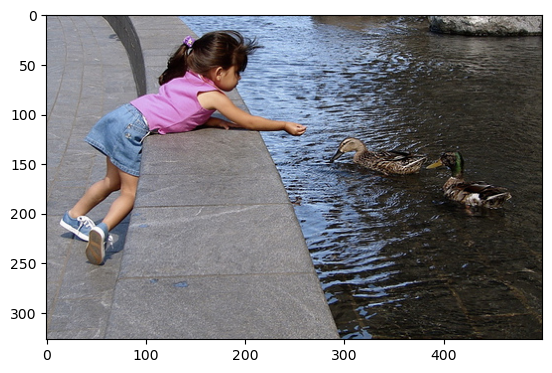

Описание: A man on an orange bike .
Лучшая вероятность: [0.53746856]
Лучший индекс: 450
Лучшее изображение:


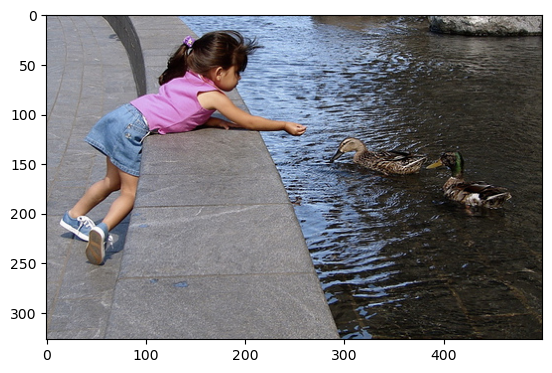

Описание: A tennis player in a blue shirt celebrates his match .
Лучшая вероятность: [0.54375063]
Лучший индекс: 450
Лучшее изображение:


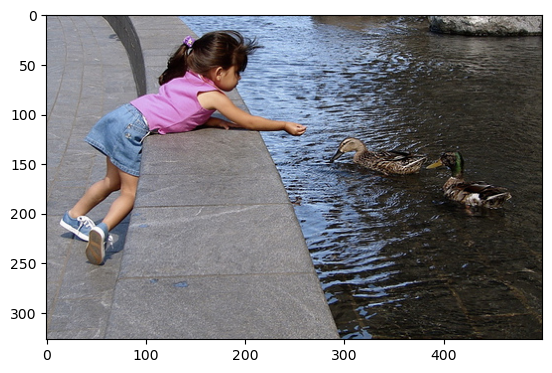

Описание: A red high speed racing boat skips across the water .
Лучшая вероятность: [0.54375063]
Лучший индекс: 450
Лучшее изображение:


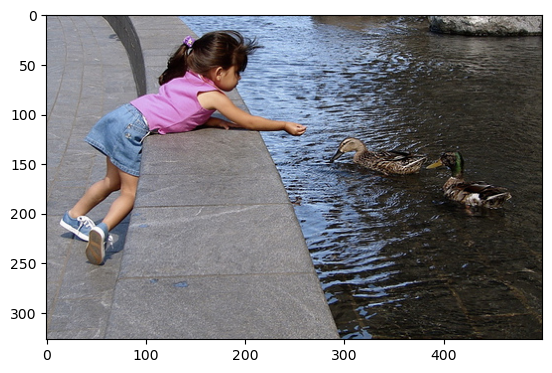

Описание: A snowboarder in a red jacket slides down a snowy mountain .
Лучшая вероятность: [0.54375063]
Лучший индекс: 450
Лучшее изображение:


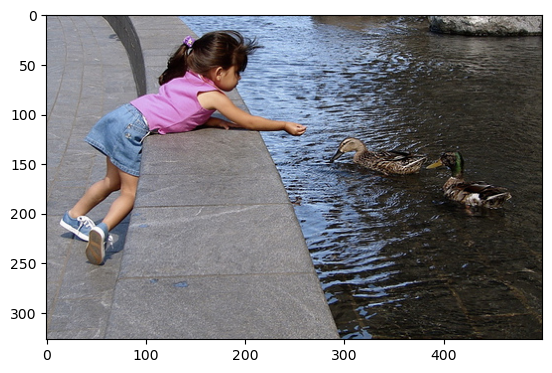

Описание: A large crowd of girls are all wearing green skirts and white tank tops .
Описание: A baby girl playing at a park .
Описание: An Asian woman is taking a photograph outside a white columned building .
Лучшая вероятность: [0.54375063]
Лучший индекс: 450
Лучшее изображение:


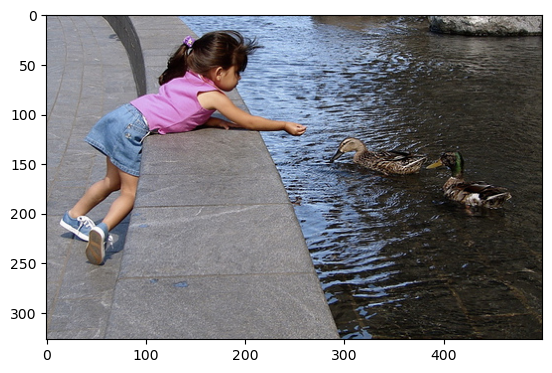

Описание: A woman wearing a red coat begins to take a picture .
Лучшая вероятность: [0.54375063]
Лучший индекс: 450
Лучшее изображение:


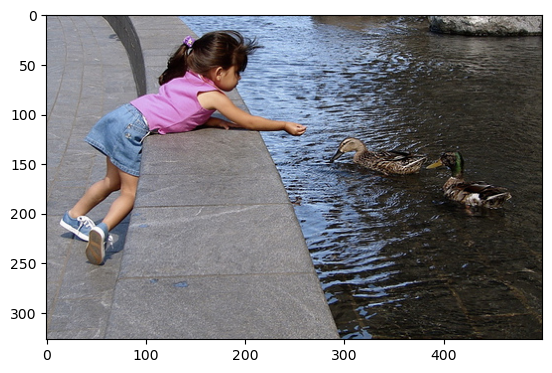

Описание: Middle school aged kids are showing their school spirit at a pep ralley .


In [ ]:
for query in queries_for_test:
    testing(query)

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска